In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import yfinance as yf
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
from IPython.display import clear_output
import pyodbc

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final
from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing
from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction

### Load data etc

In [2]:
stockInfo = pd.read_csv('../utils/stockInfo.csv',header=[0,1])

In [3]:
# How many are there contained in the file?
print('There are',
      stockInfo.shape[0],
      'tickers contained in the file, and there is data on',
      stockInfo.isnull().sum()[1:].min(),'of them.')

There are 8850 tickers contained in the file, and there is data on 5306 of them.


## Sneak peak on the 10 largest companies

In [4]:

stockInfo.sort_values(('2020-07-05','marketCap'),ascending=False).head(10)

date              2020-07-05                       
     ticker                  sector exchange     marketCap
12     AAPL              Technology      NMS  1.578173e+12
5272   MSFT              Technology      NMS  1.564160e+12
3462   GOOG  Communication Services      NMS  1.001645e+12
2733     FB  Communication Services      NMS  6.650369e+11
699    BABA       Consumer Cyclical      NYQ  5.936536e+11
8228      V      Financial Services      NYQ  4.298068e+11
4459    JNJ              Healthcare      NYQ  3.716463e+11
8583    WMT      Consumer Defensive      NYQ  3.375968e+11
4930     MA      Financial Services      NYQ  3.035511e+11
7950    TSM              Technology      NYQ  2.837483e+11

## How is the tickers divided in sectors?

In [5]:
stockInfo.loc[:,('2020-07-05')].groupby(['sector']).count()#rename(None,axis=1)

,exchange,marketCap
sector,,
Basic Materials,137,137
Communication Services,146,146
Consumer Cyclical,318,317
Consumer Defensive,130,130
Energy,204,204
Financial,3,3
Financial Services,942,942
Healthcare,607,607
Industrials,404,404


## Lets get the X largest companies in each sector.

In [6]:
sectors = stockInfo.loc[:,('2020-07-05')].dropna(axis=0).sector.unique()

X = 5

topXsectors = pd.DataFrame(index = np.arange(X),columns = pd.MultiIndex.from_product([['Top {}'.format(X)],sectors]))

t1 = pd.DataFrame({'tickers':stockInfo.loc[:,'date'].ticker.values})
t1[stockInfo.loc[:,'2020-07-05'].columns] = stockInfo.loc[:,'2020-07-05']

for i,sector in enumerate(sectors):
    
    tempSec = t1[t1.sector==sector].sort_values('marketCap',
                                                      ascending=False).dropna(axis=0).values.T
    
    Y = len(tempSec[0][0:X]) 

    topXsectors.loc[0:(Y-1),('Top {}'.format(X),sector)] = tempSec[0][0:Y]

In [7]:
topXsectors

Top 5                                                 \
  Healthcare Basic Materials Consumer Defensive Industrials   
0        JNJ             BHP                WMT         UNP   
1        NVS             LIN                 KO          BA   
2        PFE             ECL                PEP         LMT   
3       ABBV             APD               COST         UPS   
4        ABT             SHW                FMX         RTX   

                                                                         \
  Financial Services Technology Consumer Cyclical Real Estate Utilities   
0                  V       AAPL              BABA         AMT         D   
1                 MA       MSFT              TSLA         CCI        SO   
2               PYPL        TSM                TM         PLD       AEP   
3                BAC       INTC               NKE         PSA       EXC   
4                LFC       NVDA               MCD        CSGP       SRE   

                                           
  Communication Services Energy Financial  
0                   GOOG    PTR       IIM  
1                     FB     BP       ZTR  
2                      T    SNP      OTTW  
3                    DIS    ENB       NaN  
4                    CHL    PBR       NaN

In [8]:
stockInfo.head()

date          2020-07-05                       
  ticker              sector exchange     marketCap
0      A          Healthcare      NYQ  2.738234e+10
1     AA     Basic Materials      NYQ  2.039532e+09
2   AAAU                 NaN      NaN           NaN
3   AACG  Consumer Defensive      NGM  4.157730e+07
4   AADR                 NaN      NaN           NaN

In [9]:
'IYZ' in stockInfo.loc[:,('date','ticker')].values

True

In [10]:
sectors

array(['Healthcare', 'Basic Materials', 'Consumer Defensive',
       'Industrials', 'Financial Services', 'Technology',
       'Consumer Cyclical', 'Real Estate', 'Utilities',
       'Communication Services', 'Energy', 'Financial'], dtype=object)

In [11]:
## IShares Sector ETFS

# iShares Dow Jones U.S. Basic Materials Index:     IYM
# iShares Dow Jones U.S. Consumer Goods Index:      IYK
# iShares Dow Jones U.S. Consumer Services Index:   IYC
# iShares Dow Jones U.S. Energy Index:              IYE
# iShares Dow Jones U.S. Financial Sector Index:    IYF
# iShares Dow Jones U.S. Financial Services Index:  IYG
# iShares Dow Jones U.S. Healthcare Index:          IYH
# iShares Dow Jones U.S. Industrial Index:          IYJ
# iShares Dow Jones U.S. Real Estate Index:         IYR
# iShares Dow Jones U.S. Technology Index:          IYW
# iShares Dow Jones U.S. Telecommunications Index:  IYZ
# iShares Dow Jones Transportation Average Index:   IYT
# iShares Dow Jones U.S. Utilities Index:           IDU
# iShares Cohen & Steers Realty Majors Index:       ICF

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF']
# {i:j for i,j in zip(sectors,etfs)}
pd.DataFrame({i:j for i,j in zip(sectors,etfs)},index=[0])

,Healthcare,Basic Materials,Consumer Defensive,Industrials,Financial Services,Technology,Consumer Cyclical,Real Estate,Utilities,Communication Services,Energy,Financial
0,IYH,IYM,IYK,IYJ,IYG,IYW,IYC,IYR,IDU,IYZ,IYE,IYF


In [11]:
os.listdir('../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ')

['aggregateTAQ_May2020_10sec.csv',
 'aggregateTAQ_May2020_30sec.csv',
 'aggregateTAQ_May2020_60sec.csv',
 'desktop.ini']

In [24]:
datafiles = os.listdir('../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ')
content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])

'\n\naggregateTAQ_May2020_10sec.csv\naggregateTAQ_May2020_30sec.csv\naggregateTAQ_May2020_60sec.csv\n\n\n'

In [25]:
input('Which one do you want to load? %s'%''.join(content))

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec.csv
1: aggregateTAQ_May2020_30sec.csv
2: aggregateTAQ_May2020_60sec.csv


0


'0'

## Let's extract some data now!

In [2]:
# Do we extract new data or read in?
readIn = False
# run load_data()
if readIn:
    
    # Listing the data files 
    datafiles = os.listdir('../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ')
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    data = pd.read_csv('../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ/'+datafiles[int(file)],
                       header = None,
                       names=['open','high','low','close','spread_open',
                              'spread_high','spread_low','spread_close',
                              'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                              'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                              'Ticker'])
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

8559 ['taq_19930315.h5', 'taq_19930104.h5', 'taq_19930317.h5', 'taq_19930105.h5', 'taq_19930316.h5'] ['taqquote_20200624.h5', 'taqquote_20200625.h5', 'taqquote_20200626.h5', 'taqquote_20200629.h5', 'taqquote_20200630.h5']
['taqquote_20200610.h5', 'taqquote_20200615.h5', 'taqquote_20200619.h5', 'taqquote_20200622.h5', 'taqquote_20200623.h5', 'taqquote_20200624.h5', 'taqquote_20200625.h5', 'taqquote_20200626.h5', 'taqquote_20200629.h5', 'taqquote_20200630.h5']
##### Date range #####

Date, Min: 20200501
Date, Max: 20200501


1 Lap time: 2.356

##### Data Extraction begins #####

quote data is being extracted..


2 Lap time: 2.360

### Quote Data ###

3 Lap time: 2.762
4 Lap time: 2.773
The raw H5 quote file contains:  ['QuoteIndex', 'Quotes'] 

5 Lap time: 7.499
6 Lap time: 7.501
7 Lap time: 7.511
8 Lap time: 278.501
9 Lap time: 281.519
10 Lap time: 284.483
11 Lap time: 284.528
12 Lap time: 285.409
The extraction time was 286.831 seconds.


In [62]:
{i:data[data.Ticker==i].shape[0] for i in data.Ticker.unique()}

{'JNJ': 15600,
 'BHP': 15600,
 'WMT': 15600,
 'UNP': 14040,
 'V': 10920,
 'MA': 8580,
 'MSFT': 15600,
 'TSLA': 15600,
 'CCI': 14820,
 'SO': 15600,
 'FB': 14820,
 'BP': 10140,
 'PFE': 4680,
 'ECL': 3120,
 'PEP': 2340,
 'INTC': 15600,
 'NKE': 15600,
 'PSA': 15600,
 'EXC': 15600,
 'DIS': 15600,
 'ENB': 15600,
 'ABT': 14040,
 'RTX': 9360,
 'LFC': 7020,
 'NVDA': 14820,
 'IYH': 7020,
 'IYM': 11700,
 'IYC': 2340,
 'IYR': 15600,
 'SHW': 9360,
 'FMX': 10140,
 'MCD': 10140,
 'IYK': 9360,
 'IYJ': 7800,
 'BA': 8580,
 'PBR': 3120,
 'CSGP': 3900,
 'SRE': 2340,
 'CHL': 1560,
 'IYG': 3120,
 'IYW': 780,
 'KO': 780,
 'BAC': 3120}

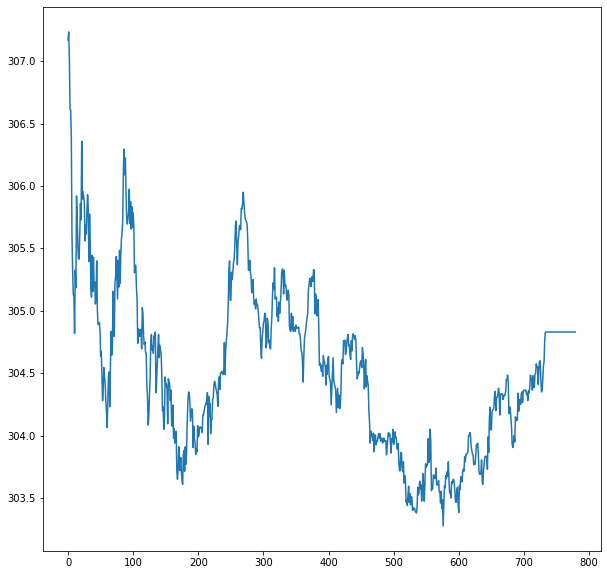

In [64]:
plt.figure(figsize=(10,10))
plt.plot(data[data.Ticker=='KO'].close.values)

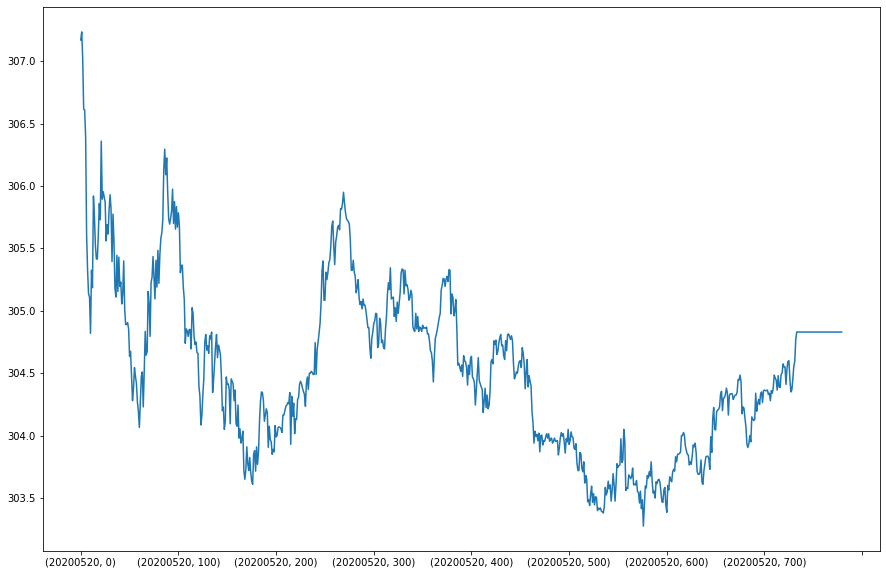

In [65]:
data[data.Ticker == 'KO'].close.plot(figsize=(15,10))
plt.show()

In [17]:
if data_sample == 'stable':
    # P1 is used for keeping data within [9.5, 16]
    cleanedData = HFDataCleaning(['P1','p2','t1','p3'],quoteData,'quote',['q'])
elif data_sample == 'full':
    # P1_2 is used for keeping data within [9, 16.5]
    cleanedData = HFDataCleaning(['P1_2','p2', 'q2', 'p3'],quoteData,'quote',['t','q'])# ,'b','x' ###'t1',tradeData # q2, quotedate
    
candles = candleCreateNP_vect_final(data = cleanedData,
                                       step = 1,
                                        verbose=False,
                                        fillHoles=True,
                                        sample='stable',
                                        numpied=True)

## Investigating load_data_and_save

In [2]:
# load_data_and_save(dates,
#                     tickers,
#                     dataNeeded,
#                     path,
#                     verbose,
#                     extract_candles = False,
#                     aggHorizon = 1,
#                     extra_features_from_quotes = None,
#                     data_sample = 'full',
#                     exchanges = ['q','t'],
#                     save_output = False)

# print(os.listdir())
try:
    path = 'a:/taqhdf5'  #'a:/taqhdf5'
    os.listdir(path)
except:
    path = 't:/taqhdf5'  #'a:/taqhdf5'
    os.listdir(path)


dates = np.array(['20200501',
                  '20200504',
                  '20200505',
#                   '20200506',
#                   '20200507',
#                   '20200508',
#                   '20200511',
#                   '20200512',
#                   '20200513',
#                   '20200514',
#                   '20200515',
#                   '20200518',
#                   '20200519',
#                   '20200520',
#                   '20200521',
#                   '20200522',
#                   '20200526',
#                   '20200527',
#                   '20200528',
#                   '20200529'
                  
                  
                 ]).astype(int)#,'20200401','20200402','20200403','20200406','20200407'

# Provide a list of tickers of interest
tickers = sorted(['TSLA','FB'])#all_tickers # ['GOOG']#'MSFT' ['GOOG', 'MSFT'] ##  'KO','CHL'

# Do we need data on trades, quotes or both?
dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'

# extract_candles = True #False
aggHorizon = [1/6,1/2,1] # in minutes
extra_features_from_quotes = ['spread', 'bidsize', 'ofrsize']

data_sample = 'full'
save_output = True

data = load_data_and_save(dates,
                            tickers,
                            dataNeeded,
                            path,
                            verbose,
                            extract_candles = False,
                            aggHorizon = aggHorizon,
                            extra_features_from_quotes = extra_features_from_quotes,
                            data_sample = data_sample,
                            exchanges = ['q'],#,'t'
                            save_output=save_output)

8559 ['taq_19930315.h5', 'taq_19930104.h5', 'taq_19930317.h5', 'taq_19930105.h5', 'taq_19930316.h5'] ['taqquote_20200624.h5', 'taqquote_20200625.h5', 'taqquote_20200626.h5', 'taqquote_20200629.h5', 'taqquote_20200630.h5']
['taqquote_20200610.h5', 'taqquote_20200615.h5', 'taqquote_20200619.h5', 'taqquote_20200622.h5', 'taqquote_20200623.h5', 'taqquote_20200624.h5', 'taqquote_20200625.h5', 'taqquote_20200626.h5', 'taqquote_20200629.h5', 'taqquote_20200630.h5']
##### Date range #####

Date, Min: 20200501
Date, Max: 20200505


1 Lap time: 1.985

##### Data Extraction begins #####

quote data is being extracted..


2 Lap time: 1.990

### Quote Data ###

3 Lap time: 2.433
4 Lap time: 2.446
The raw H5 quote file contains:  ['QuoteIndex', 'Quotes'] 

5 Lap time: 6.962
6 Lap time: 6.964
7 Lap time: 6.974
8 Lap time: 275.277
9 Lap time: 278.809
10 Lap time: 282.072
11 Lap time: 282.129
12 Lap time: 283.023
3 Lap time: 303.123
4 Lap time: 303.136
5 Lap time: 310.582
6 Lap time: 310.585
7 Lap time

In [3]:
data

In [6]:
data[data.Ticker=='TSLA']

,utcsec,ex,bid,bidsize,ofr,ofrsize,mode,Date,Timestamp,Ticker,price,spread
0,14400008795117,Q,0.00,0,219.99,1,R,20200501,2020-05-01 04:00:00.008795117,TSLA,109.995,219.99
1,14400009342377,Q,0.00,0,218.99,1,R,20200501,2020-05-01 04:00:00.009342377,TSLA,109.495,218.99
2,14400049539405,P,200.00,1,0.00,0,R,20200501,2020-05-01 04:00:00.049539405,TSLA,100.000,-200.00
3,14400049545248,P,200.00,1,218.00,1,R,20200501,2020-05-01 04:00:00.049545248,TSLA,209.000,18.00
4,14400049545467,P,200.00,1,212.00,1,R,20200501,2020-05-01 04:00:00.049545467,TSLA,206.000,12.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1757321,42314616094322,X,700.12,1,700.77,2,R,20200501,2020-05-01 11:45:14.616094322,TSLA,700.445,0.65
1757322,42314616097562,X,700.12,1,700.77,3,R,20200501,2020-05-01 11:45:14.616097562,TSLA,700.445,0.65
1757323,42314616099513,Q,700.00,184,700.13,3,R,20200501,2020-05-01 11:45:14.616099513,TSLA,700.065,0.13
1757324,42314616110173,Q,700.00,184,700.90,1,R,20200501,2020-05-01 11:45:14.616110173,TSLA,700.450,0.90


In [10]:
quoteData

,utcsec,ex,bid,bidsize,ofr,ofrsize,mode,Date,Timestamp,Ticker,price,spread
0,14400008795117,Q,0.0,0,219.99,1,R,20200501,2020-05-01 04:00:00.008795117,TSLA,109.995,219.99
1,14400009342377,Q,0.0,0,218.99,1,R,20200501,2020-05-01 04:00:00.009342377,TSLA,109.495,218.99
2,14400049539405,P,200.0,1,0.00,0,R,20200501,2020-05-01 04:00:00.049539405,TSLA,100.000,-200.00
3,14400049545248,P,200.0,1,218.00,1,R,20200501,2020-05-01 04:00:00.049545248,TSLA,209.000,18.00
4,14400049545467,P,200.0,1,212.00,1,R,20200501,2020-05-01 04:00:00.049545467,TSLA,206.000,12.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2763189,71996974108001,K,704.0,1,709.00,20,R,20200501,2020-05-01 19:59:56.974108001,FB,706.500,5.00
2763190,71997226615556,K,704.0,2,709.00,20,R,20200501,2020-05-01 19:59:57.226615556,FB,706.500,5.00
2763191,71997423917077,K,704.0,2,709.00,20,R,20200501,2020-05-01 19:59:57.423917077,FB,706.500,5.00
2763192,71997741445556,Q,704.0,3,708.39,1,R,20200501,2020-05-01 19:59:57.741445556,FB,706.195,4.39


In [4]:
test = pd.read_csv('aggregateTAQ_60sec.csv',header=None)

In [5]:
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,20200501,0,201.800,202.715,201.170,202.615,0.40,0.92,0.01,0.11,2,19,1,1,4,161,1,3,FB
1,20200501,1,202.605,202.870,201.840,202.680,0.09,0.38,0.01,0.04,1,28,1,1,1,5,1,2,FB
2,20200501,2,202.680,203.200,202.280,202.375,0.04,0.34,0.01,0.17,1,26,1,1,1,122,1,1,FB
3,20200501,3,202.360,203.460,202.355,203.385,0.20,0.31,0.01,0.17,1,11,1,1,1,24,1,3,FB
4,20200501,4,203.385,204.295,203.385,204.235,0.17,0.26,0.01,0.09,1,7,1,1,2,350,1,2,FB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,20200505,385,769.785,770.155,768.135,770.005,0.95,1.69,0.10,0.99,1,10,1,2,1,8,1,4,TSLA
2336,20200505,386,769.955,770.005,767.580,767.725,0.89,1.14,0.17,0.61,2,7,1,2,1,4,1,2,TSLA
2337,20200505,387,767.745,769.495,767.650,768.630,0.57,1.79,0.26,0.80,1,2,1,1,2,3,1,1,TSLA
2338,20200505,388,768.635,769.600,767.365,769.185,0.79,1.36,0.02,0.99,1,16,1,2,1,9,1,1,TSLA


In [6]:
test[test[18]=='TSLA']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
390,20200501,0,755.140,762.530,753.500,762.215,1.72,4.42,0.02,1.37,1,7,1,1,5,26,1,2,TSLA
391,20200501,1,762.265,763.480,755.065,757.875,1.47,5.91,0.13,1.33,1,7,1,2,15,15,1,1,TSLA
392,20200501,2,757.875,760.225,756.795,758.915,1.33,3.58,0.01,0.81,2,10,1,1,2,7,1,1,TSLA
393,20200501,3,758.920,764.795,755.985,764.475,0.82,3.20,0.01,1.05,1,10,1,1,4,30,1,30,TSLA
394,20200501,4,764.475,772.745,764.130,770.750,1.05,2.98,0.01,0.84,1,20,1,1,31,31,1,1,TSLA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,20200505,385,769.785,770.155,768.135,770.005,0.95,1.69,0.10,0.99,1,10,1,2,1,8,1,4,TSLA
2336,20200505,386,769.955,770.005,767.580,767.725,0.89,1.14,0.17,0.61,2,7,1,2,1,4,1,2,TSLA
2337,20200505,387,767.745,769.495,767.650,768.630,0.57,1.79,0.26,0.80,1,2,1,1,2,3,1,1,TSLA
2338,20200505,388,768.635,769.600,767.365,769.185,0.79,1.36,0.02,0.99,1,16,1,2,1,9,1,1,TSLA


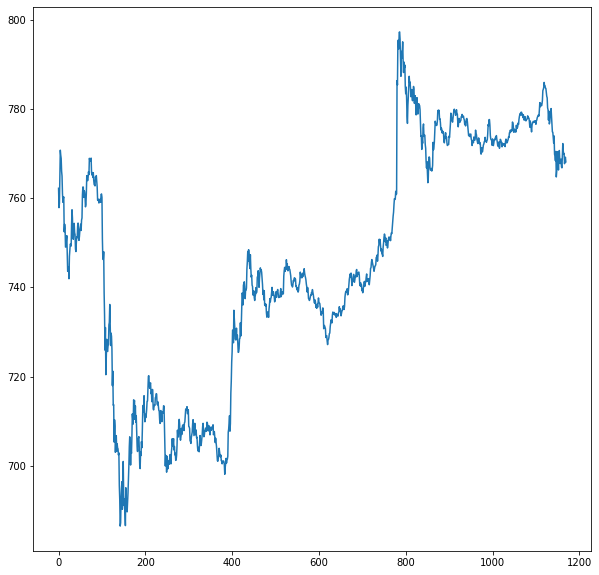

In [7]:
plt.figure(figsize=(10,10))
plt.plot(test[test[18]=='TSLA'][5].values)
plt.show()

In [8]:
test1 = pd.read_csv('aggregateTAQ_30sec.csv',header=None)

In [10]:
test1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,20200501,0,201.800,202.340,201.170,202.210,0.40,0.92,0.01,0.04,2,19,1,5,4,161,1,1,FB
1,20200501,1,202.235,202.715,202.045,202.615,0.09,0.28,0.01,0.11,5,5,1,1,1,39,1,3,FB
2,20200501,2,202.605,202.870,201.840,202.185,0.09,0.35,0.01,0.07,1,4,1,2,1,5,1,2,FB
3,20200501,3,202.185,202.680,201.960,202.680,0.07,0.38,0.01,0.04,2,28,1,1,1,5,1,2,FB
4,20200501,4,202.680,203.060,202.575,203.060,0.04,0.20,0.01,0.08,1,24,1,1,1,122,1,3,FB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4675,20200505,775,768.750,769.290,768.630,768.630,0.84,1.00,0.36,0.80,1,2,1,1,1,3,1,1,TSLA
4676,20200505,776,768.635,768.740,767.365,768.350,0.79,1.36,0.08,0.54,1,16,1,1,1,5,1,1,TSLA
4677,20200505,777,768.360,769.600,768.205,769.185,0.56,1.11,0.02,0.99,1,7,1,2,1,9,1,1,TSLA
4678,20200505,778,769.025,769.180,768.155,768.155,0.67,0.93,0.11,0.93,2,10,1,5,2,10,1,3,TSLA


In [11]:
test1[test1[18]=='TSLA']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
780,20200501,0,755.140,762.530,753.500,760.945,1.72,4.42,0.02,3.33,1,7,1,1,5,26,1,2,TSLA
781,20200501,1,760.595,762.215,758.900,762.215,2.63,3.62,0.78,1.37,1,7,1,1,1,2,1,2,TSLA
782,20200501,2,762.265,763.480,755.065,759.075,1.47,5.91,0.13,1.85,1,7,1,2,15,15,1,1,TSLA
783,20200501,3,759.075,760.165,756.645,757.875,1.85,4.49,0.98,1.33,3,3,1,2,1,3,1,1,TSLA
784,20200501,4,757.875,760.020,756.795,757.985,1.33,3.58,0.01,1.97,2,10,1,1,2,7,1,1,TSLA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4675,20200505,775,768.750,769.290,768.630,768.630,0.84,1.00,0.36,0.80,1,2,1,1,1,3,1,1,TSLA
4676,20200505,776,768.635,768.740,767.365,768.350,0.79,1.36,0.08,0.54,1,16,1,1,1,5,1,1,TSLA
4677,20200505,777,768.360,769.600,768.205,769.185,0.56,1.11,0.02,0.99,1,7,1,2,1,9,1,1,TSLA
4678,20200505,778,769.025,769.180,768.155,768.155,0.67,0.93,0.11,0.93,2,10,1,5,2,10,1,3,TSLA


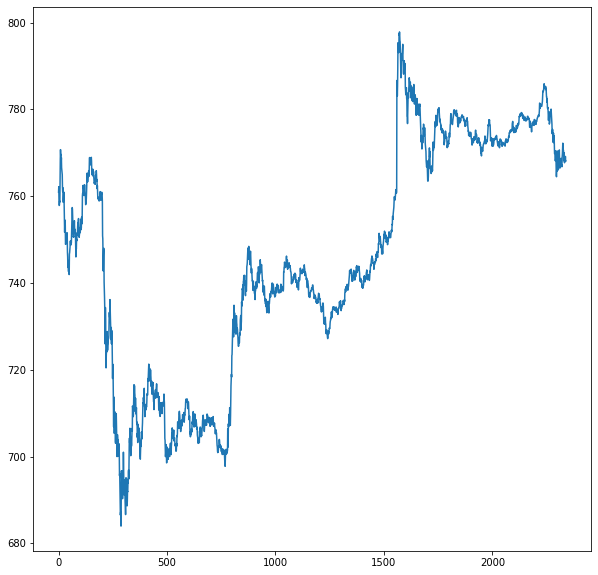

In [13]:
plt.figure(figsize=(10,10))
plt.plot(test1[test1[18]=='TSLA'][5].values)
plt.show()

In [14]:
test2 = pd.read_csv('aggregateTAQ_10sec.csv',header=None)

In [15]:
test2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,20200501,0,201.800,201.800,201.170,201.305,0.40,0.92,0.02,0.15,2.0,14.0,1.0,1.0,4.0,17.0,1.0,1.0,FB
1,20200501,1,201.285,202.200,201.285,202.200,0.11,0.23,0.01,0.08,1.0,19.0,1.0,1.0,1.0,161.0,1.0,5.0,FB
2,20200501,2,202.200,202.340,202.125,202.210,0.08,0.21,0.01,0.04,1.0,16.0,1.0,5.0,4.0,4.0,1.0,1.0,FB
3,20200501,3,202.235,202.600,202.145,202.145,0.09,0.24,0.01,0.15,5.0,5.0,1.0,2.0,1.0,39.0,1.0,2.0,FB
4,20200501,4,202.145,202.250,202.045,202.250,0.15,0.28,0.05,0.16,1.0,4.0,1.0,2.0,2.0,4.0,1.0,2.0,FB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14035,20200505,2335,769.180,769.180,768.540,768.540,0.22,0.70,0.13,0.38,1.0,4.0,1.0,2.0,5.0,10.0,1.0,2.0,TSLA
14036,20200505,2336,768.540,768.655,768.155,768.155,0.38,0.93,0.19,0.93,2.0,10.0,1.0,5.0,3.0,3.0,1.0,3.0,TSLA
14037,20200505,2337,767.990,768.045,767.375,767.645,0.60,0.90,0.12,0.61,5.0,7.0,1.0,1.0,1.0,9.0,1.0,3.0,TSLA
14038,20200505,2338,767.655,767.955,767.500,767.625,0.59,0.77,0.01,0.25,1.0,5.0,1.0,4.0,3.0,10.0,1.0,10.0,TSLA


In [16]:
test2[test2[18]=='TSLA']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
2340,20200501,0,755.140,757.625,753.500,757.625,1.72,2.69,0.02,0.75,1.0,7.0,1.0,2.0,5.0,10.0,1.0,4.0,TSLA
2341,20200501,1,757.820,762.525,757.625,762.525,0.36,2.29,0.11,0.95,1.0,3.0,1.0,1.0,4.0,26.0,1.0,15.0,TSLA
2342,20200501,2,762.525,762.530,760.400,760.945,0.95,4.42,0.58,3.33,1.0,2.0,1.0,1.0,14.0,14.0,1.0,2.0,TSLA
2343,20200501,3,760.595,761.095,758.900,759.000,2.63,3.61,1.08,2.00,1.0,3.0,1.0,3.0,1.0,2.0,1.0,1.0,TSLA
2344,20200501,4,759.000,760.750,759.000,759.230,2.00,3.62,0.78,2.46,4.0,7.0,1.0,6.0,1.0,1.0,1.0,1.0,TSLA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14035,20200505,2335,769.180,769.180,768.540,768.540,0.22,0.70,0.13,0.38,1.0,4.0,1.0,2.0,5.0,10.0,1.0,2.0,TSLA
14036,20200505,2336,768.540,768.655,768.155,768.155,0.38,0.93,0.19,0.93,2.0,10.0,1.0,5.0,3.0,3.0,1.0,3.0,TSLA
14037,20200505,2337,767.990,768.045,767.375,767.645,0.60,0.90,0.12,0.61,5.0,7.0,1.0,1.0,1.0,9.0,1.0,3.0,TSLA
14038,20200505,2338,767.655,767.955,767.500,767.625,0.59,0.77,0.01,0.25,1.0,5.0,1.0,4.0,3.0,10.0,1.0,10.0,TSLA


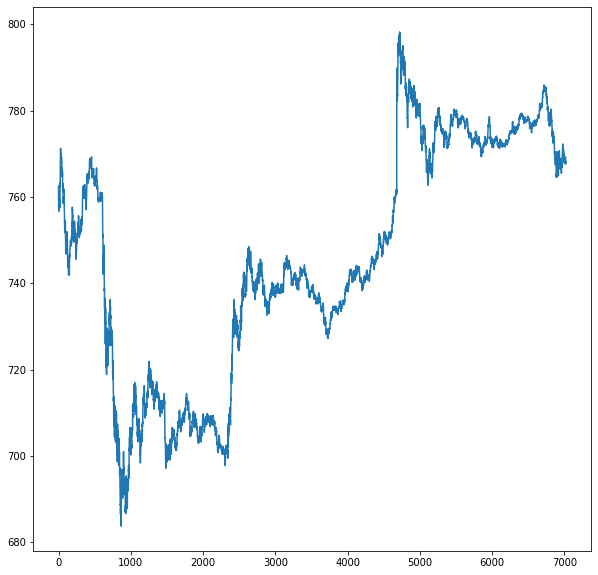

In [17]:
plt.figure(figsize=(10,10))
plt.plot(test2[test2[18]=='TSLA'][5].values)
plt.show()

# Data Cleaning, Feature Engineering & Pre Processing

## Features

A library: https://technical-analysis-library-in-python.readthedocs.io/en/latest/

### Features used in the literature:

* Stochastic K
* Stochastic D
* Slow Stochastic D
* Momentum/difference
* ROC
* Williams % R
* A/D Oscillator
* Disparity 5
* Disparity 10
* Price Oscillator - (detrended)
* Commodity Channel Index
* RSI

Formulas: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=876544

* Moving Average
* Exponential Moving Average
* True Range - (Average)

Formulas: https://www.sciencedirect.com/science/article/pii/S0957417407001819?via%3Dihub

#### Other Technical Features
* Moving Average Convergence Divergence (MACD)
* Bid/Ask prices of top of book
* Spread and mid price based on top of book

**All of the above features are implemented.**

**Non-classical technical features** - **NOT IMPLEMENTED**

* Price derivatives

Formulas: https://www.tandfonline.com/doi/full/10.1080/14697688.2015.1032546?instName=UCL+%28University+College+London%29

In [5]:

############################################## Redudant at the moment, ###################################################
############################## as cleaning and candling happens inside the load function #################################
########### Clean data ###########
    
# DATA_SAMPLE = 'full' # or 'stable'

# if DATA_SAMPLE == 'stable':
#     # P1 is used for keeping data within [9.5, 16]
#     cleanedData = HFDataCleaning(['P1','p2','t1','p3'],tradeData,'trade',['q'])
# elif DATA_SAMPLE == 'full':
#     # P1_2 is used for keeping data within [9, 16.5]
#     cleanedData = HFDataCleaning(['P1_2','p2', 'q2', 'p3'],quoteData,'quote',['q'])#'t1',tradeData # q2, quotedate
    
# ########### Construct Candles ################
# # candles = candleCreateNP_vect_final(cleanedData
# #                          ,1)

# candles = candleCreateNP_vect_final(data = cleanedData,
#                                        step = 1,
#                                         verbose=False,
#                                         fillHoles=True,
#                                         sample='stable',
#                                         numpied=True)
##########################################################################################################################
########### Generate Features ################

n_feature_lags = 0
features = generateFeatures_final(data = candles, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'stok',
                                                    'stod',
                                                    'sstod',
                                                    'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                    'dis5',
                                                    'dis10',
                                                   ], 
                                   feature_lags = n_feature_lags)

########### Generate Labels ################

n_classes = 3

labels = extract_labels(data = candles, classes = n_classes, group_style = 'equal')

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y = align_features_and_labels(candles = candles, 
                                 prediction_horizon = 1, 
                                 features = features, 
                                 n_feature_lags = n_feature_lags, 
                                 n_classes = n_classes, # 5,
                                 safe_burn_in = False, 
                                 data_sample = 'full')

In [16]:
X.describe()

,open,high,low,close,stok,stod,sstod,wilr,roc,rsi,atr,cci,dpo,sma,ema,macd,macd_diff,macd_signal,dis5,dis10
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,1113.773258,1114.526629,1112.868174,1113.757767,45.965678,45.866528,45.018269,-54.034322,-0.033712,46.510800,1.667143,-29.389592,0.021178,1113.916745,1113.940554,-0.352790,0.034606,-0.387397,99.995090,99.988762
std,8.044471,8.083798,8.043112,8.063764,30.592797,28.171470,20.774258,30.592797,0.312338,9.771436,0.377615,104.655551,1.444503,7.880745,7.826475,0.898852,0.349058,0.808610,0.108266,0.158964
min,1097.575000,1099.175000,1097.375000,1097.590000,0.000000,1.742517,10.260569,-100.000000,-0.698726,22.065871,1.116435,-257.657044,-4.806000,1099.746667,1099.899247,-2.605586,-0.615902,-2.200649,99.720445,99.632080
25%,1108.207500,1108.968750,1107.286250,1108.158750,16.986568,19.694642,28.553813,-83.013432,-0.259309,38.838962,1.416167,-106.727739,-0.875187,1108.346771,1108.331645,-1.084540,-0.195433,-1.020117,99.921990,99.885761
50%,1111.632500,1112.212500,1110.602500,1111.612500,43.191829,42.603679,42.059838,-56.808171,-0.094255,46.184344,1.593985,-51.517723,0.220750,1111.189167,1111.078969,-0.368386,-0.027618,-0.374518,99.994655,99.966343
75%,1121.457500,1122.060000,1120.492500,1121.567500,73.043017,71.131080,61.557961,-26.956983,0.125682,53.717224,1.833109,52.922946,1.030063,1120.916979,1121.278897,0.259694,0.219287,0.211788,100.064057,100.075917
max,1129.185000,1129.885000,1128.145000,1129.090000,100.000000,99.180868,90.629735,-0.000000,1.041685,69.924603,2.970880,313.669065,3.248000,1127.830833,1127.388950,1.816809,1.152648,1.328417,100.418115,100.571381


## Pre-Processing

## Pre-Processing used in literature
                        Pre-Processing technique

[Persio and Honchar](https://docs.google.com/document/d/1arQLNFooYBRW8GXZHsALdtUKgRgtqWmfd693FD2tiwg/edit#bookmark=id.wp17pdeo3tpi): **Standardization of returns** over the period of interest (if they want to predict the price of the next minute, they use returns over one minute)<br>
[Banerjee et al.](https://docs.google.com/document/d/1arQLNFooYBRW8GXZHsALdtUKgRgtqWmfd693FD2tiwg/edit#bookmark=id.r0fkhmtptn19): **Discretization** - If the price today is less than yesterdays price a 0 is returned, and if the price is higher a 1 is returned.<br>
[Dey et al.](https://docs.google.com/document/d/1arQLNFooYBRW8GXZHsALdtUKgRgtqWmfd693FD2tiwg/edit#bookmark=id.6h46q7r6rp1a): **Exponential smoothing** of the price series, which they then calculate technical features on.<br>
[Rodriguez and Rodriguez](https://docs.google.com/document/d/1arQLNFooYBRW8GXZHsALdtUKgRgtqWmfd693FD2tiwg/edit#bookmark=id.yev5wsr0nvsj): **Standardization** of all technical features.<br>
[Kumar and Thenmozhi](https://docs.google.com/document/d/1arQLNFooYBRW8GXZHsALdtUKgRgtqWmfd693FD2tiwg/edit#bookmark=id.eutmb3tljd4c): **Min-Max Normalization.**<br>
[Huang et al.](https://docs.google.com/document/d/1arQLNFooYBRW8GXZHsALdtUKgRgtqWmfd693FD2tiwg/edit#bookmark=id.l8dgjgqtvcfe): **None** - No pre-processing is mentioned in their paper.<br>
[Senol and Ozturan](https://docs.google.com/document/d/1arQLNFooYBRW8GXZHsALdtUKgRgtqWmfd693FD2tiwg/edit#bookmark=id.ok29rx55z2hz): **None** - No pre-processing is mentioned in their paper.<br>
[Ou and Wang](https://docs.google.com/document/d/1arQLNFooYBRW8GXZHsALdtUKgRgtqWmfd693FD2tiwg/edit#bookmark=id.2aqx0ddlb2l8): **None** - No pre-processing is mentioned in their paper.<br>
[Subha and Nambi](https://docs.google.com/document/d/1arQLNFooYBRW8GXZHsALdtUKgRgtqWmfd693FD2tiwg/edit#bookmark=id.27ti4ehq9ld9): **None** - No pre-processing is mentioned in their paper.<br>

## Standardization, Normalization (MinMax), Norm-Scaling, Quantile and Power Transformation

**Inspiration:**

* [ScikitLearn Overview](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)
* [A Note on Feature Scaling and Normalization](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html)

In [3]:
# Setting up the Scalers!
mm_scaler = MinMaxScaler()
scaler = StandardScaler()
norm_scaler = Normalizer()
pt = PowerTransformer()
ptNst = PowerTransformer(standardize=False)
qtUni = QuantileTransformer(n_quantiles=100)
qtGau = QuantileTransformer(n_quantiles=100,output_distribution='normal')
robo = RobustScaler()


For now, we remove features if they are easily scaled down to a desireable range, thereby focusing on the rest.
Features are listed below, as good down-scaling procedures are identified. 

Parentheses indicates that the scaling procedure could work but it is not ideal.

**Open**: Std, Power (Std.), (MinMax) <br>
**High**: Std, Power (Std.), (MinMax)<br>
**Low**: Std, Power (Std.), (MinMax)<br>
**Close**: Std, Power (Std.), (MinMax)<br>
**Stok**: Std, Power (Std.), (MinMax), (Norm)<br>
**Stod**: Std, Power (Std.), (MinMax), (Norm)<br>
**SStod**: Std, Power (Std.), (MinMax), (Norm)<br>
**Wilr**: Std, Power (Std.), (MinMax), (Norm)<br>
**ema**: Std, Power (Std.), (MinMax)<br>
**sma**: Std, Power (Std.), (MinMax)<br>
**Dis5**: Substract 100 <br>
**Dis10**: Substract 100 <br>
**Macd_diff**: baseline <br>
**Roc**: baseline demeaned<br>
**Atr**: baseline demeaned <br>
**Rsi**: Std., Quantile Transformation (Gaussian), Power (Std.) <br>
**Cci**: Quantile Transformation (Gaussian), (Power (Std.)) <br>
**Dpo**: Quantile Transformation (Gaussian),  (Norm) <br>
**Macd**: Quantile Transformation (Gaussian) <br>
**Macd_Signal**: Quantile Transformation (Gaussian) <br>


In [70]:
# tempX = X.drop(columns=['open',
#                         'high',
#                         'low',
#                         'close',
#                         'stok',
#                         'stod',
#                         'sstod',
#                         'wilr',
#                         'sma',
#                         'ema',
#                         'dis5',
#                         'dis10',
#                         'macd_diff',
#                         'roc',
#                         'atr',
#                         'rsi']).copy(deep=True)
tempX = X.copy(deep=True)

In [67]:
tempX.describe()

,open_lag0,high_lag0,low_lag0,close_lag0,stok_lag0,stod_lag0,sstod_lag0,wilr_lag0,roc_lag0,rsi_lag0,...,atr_lag5,cci_lag5,dpo_lag5,sma_lag5,ema_lag5,macd_lag5,macd_diff_lag5,macd_signal_lag5,dis5_lag5,dis10_lag5
count,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8.151000e+03,8151.000000,8151.000000,8151.000000,8151.000000,...,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000
mean,1232.696161,1233.376378,1231.986045,1232.684743,52.520241,5.251936e+01,52.479199,-47.479759,0.028285,51.047264,...,1.525800,5.762215,-0.040370,1232.395297,1232.395989,0.183717,0.001064,0.182653,100.004548,100.010128
std,65.843459,65.780694,65.918905,65.856646,32.569614,3.041830e+01,24.251622,32.569614,0.529048,12.630987,...,0.773459,112.314635,2.538452,65.815006,65.788603,2.082944,0.633812,1.959266,0.166951,0.258131
min,1080.010000,1080.800000,1079.780000,1079.880000,0.000000,1.219765e-13,3.882960,-100.000000,-2.896472,10.633332,...,0.543539,-536.642963,-59.749500,1081.999167,1082.265928,-8.987732,-4.180436,-7.829401,98.843022,98.559192
25%,1199.590000,1200.210000,1198.760000,1199.570000,22.003754,2.350795e+01,31.660256,-77.996246,-0.187800,42.484549,...,1.054834,-81.297776,-0.933250,1199.194583,1199.328542,-0.728663,-0.244001,-0.691285,99.941712,99.908169
50%,1251.930000,1252.690000,1251.280000,1251.960000,54.376658,5.407961e+01,53.864250,-45.623342,0.016798,51.175290,...,1.328626,14.120345,-0.005000,1252.054167,1251.961299,0.093018,-0.016066,0.098722,100.003566,100.007622
75%,1275.645000,1276.075000,1275.120000,1275.620000,82.985923,8.198961e+01,73.411488,-17.014077,0.204589,59.866106,...,1.691335,93.491310,0.891750,1275.687917,1275.605591,0.908579,0.233037,0.854986,100.060402,100.097404
max,1358.565000,1360.000000,1358.130000,1358.790000,100.000000,1.000000e+02,95.943559,-0.000000,9.066019,92.567373,...,9.703080,666.666667,43.795000,1357.719167,1357.329574,28.679766,13.126366,23.858974,106.706318,107.654596


## Baseline

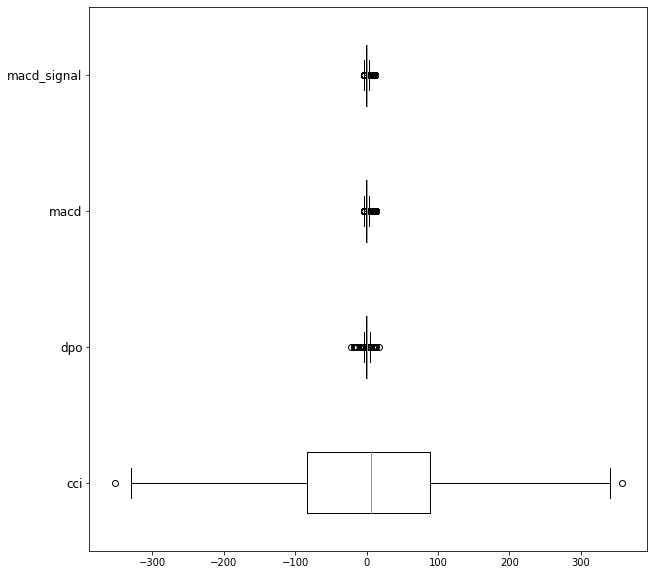

In [142]:
# tempX = tempX.drop(columns=['cci'])
plt.figure(figsize=(10,10))
plt.boxplot(tempX.values,vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

In [130]:
val = tempX.roc
print('Min: ',round(val.min(),3),
      '\nMax: ',round(val.max(),3),
      '\nMedian: ',round(val.median(),3),
      '\nMean: ',round(val.mean(),3))

AttributeError: 'DataFrame' object has no attribute 'roc'

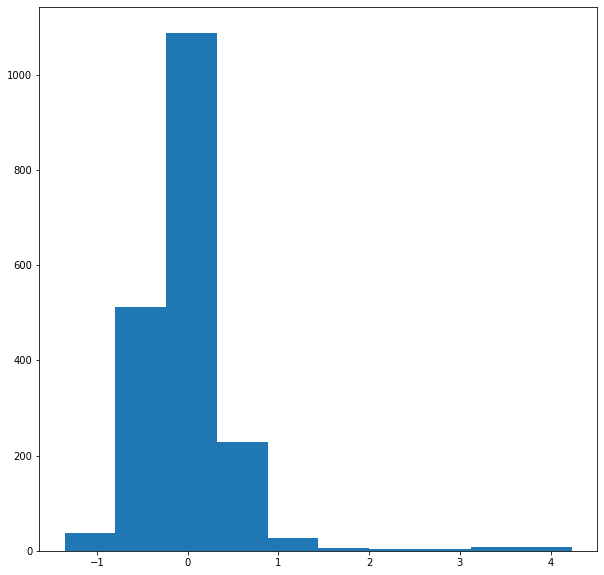

In [131]:
plt.figure(figsize=(10,10))
plt.hist((val-val.mean()))#-tempX.atr.mean()
plt.show()

## Standardization

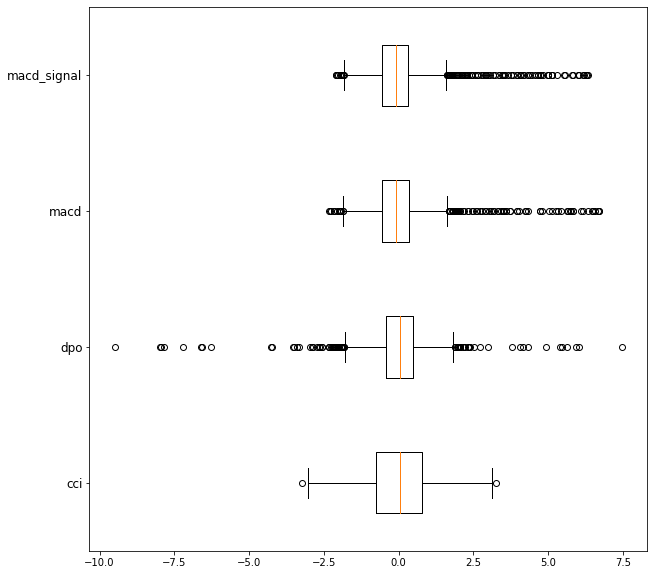

In [132]:
plt.figure(figsize=(10,10))
plt.boxplot(scaler.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Normalization

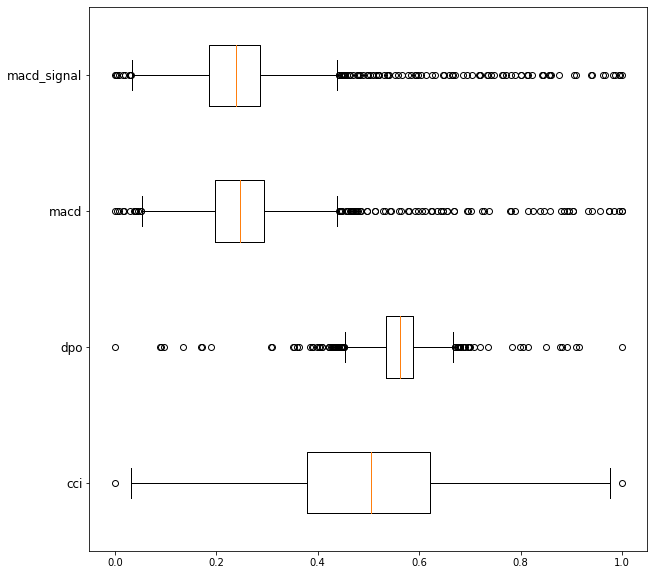

In [133]:
plt.figure(figsize=(10,10))
plt.boxplot(mm_scaler.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Norm-Scaling

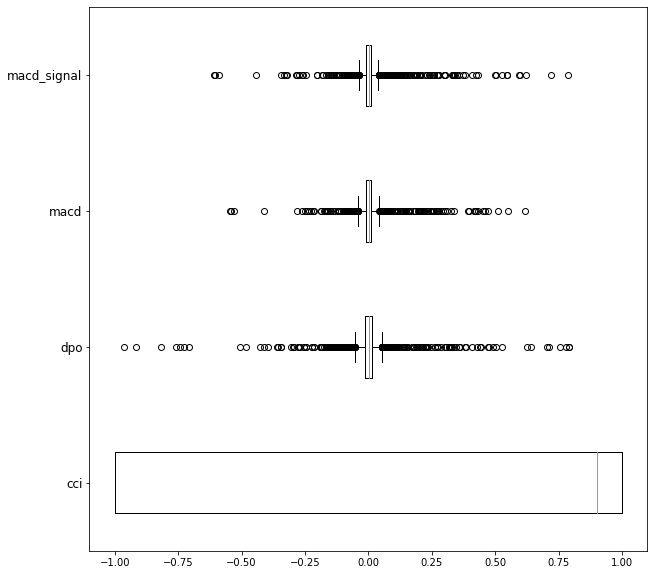

In [134]:
plt.figure(figsize=(10,10))
plt.boxplot(norm_scaler.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Quantile Transformation (Uniform)

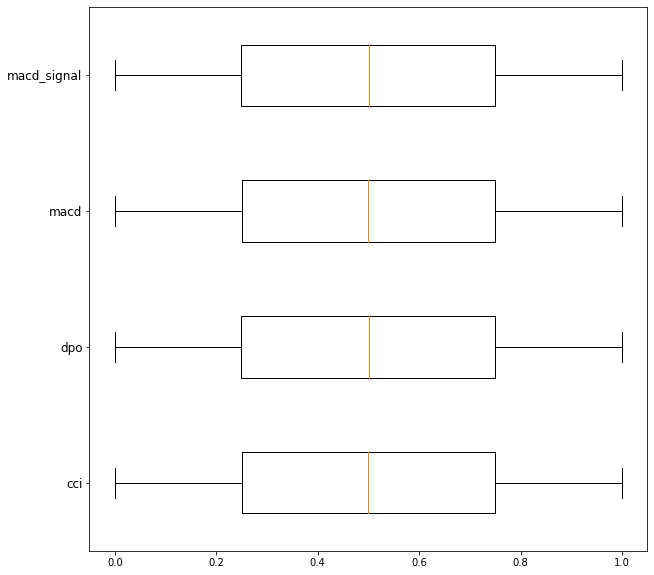

In [135]:
plt.figure(figsize=(10,10))
plt.boxplot(qtUni.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Quantile Transform (Gaussian)

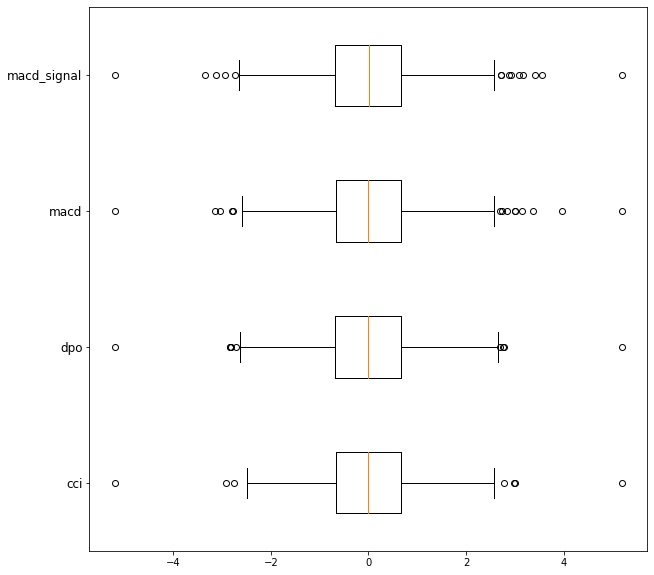

In [136]:
plt.figure(figsize=(10,10))
plt.boxplot(qtGau.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Power Transformation (Standardized)

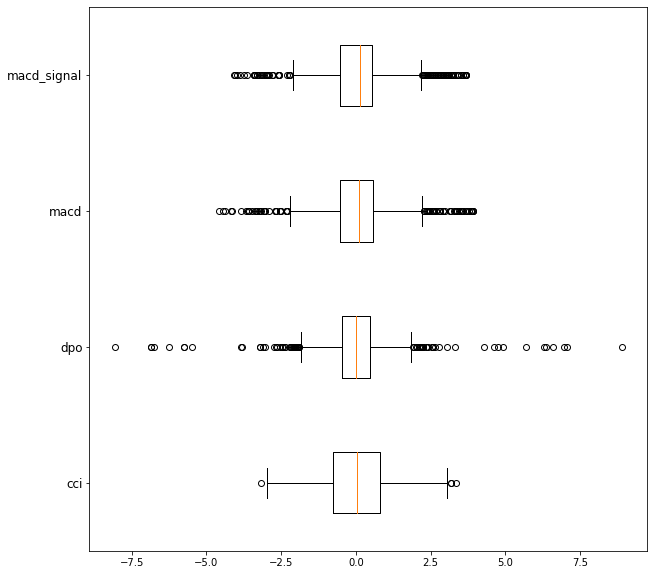

In [137]:
plt.figure(figsize=(10,10))
plt.boxplot(pt.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Power (Not Standardized)

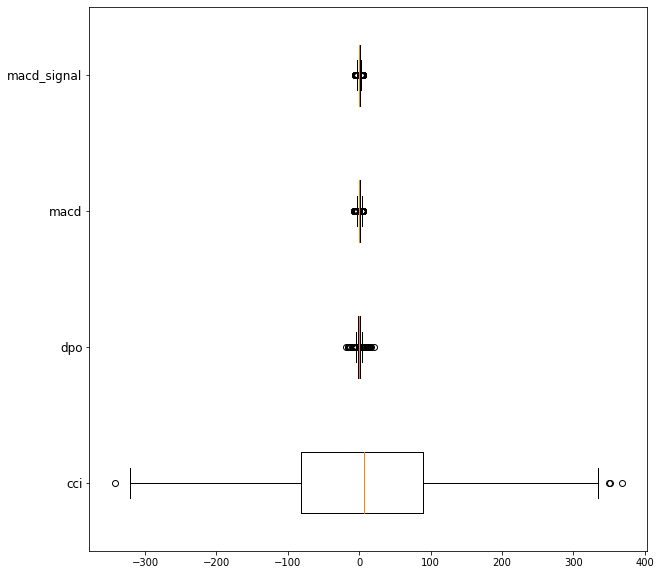

In [138]:
# tempX = tempX.drop(columns=['cci'])
plt.figure(figsize=(10,10))
plt.boxplot(ptNst.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Robust Scaler

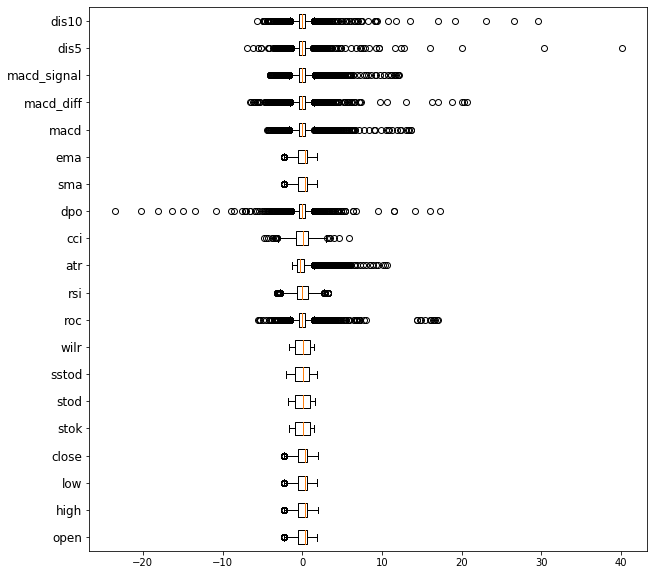

In [79]:
# tempX = tempX.drop(columns=['cci'])
plt.figure(figsize=(10,10))
plt.boxplot(robo.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

In [77]:
pd.DataFrame(scaler.fit_transform(robo.fit_transform(tempX)),columns = tempX.columns).describe()

,open,high,low,close,stok,stod,sstod,wilr,roc,rsi,atr,cci,dpo,sma,ema,macd,macd_diff,macd_signal,dis5,dis10
count,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03
mean,-5.721814e-16,6.533927e-19,-1.032633e-16,1.338557e-15,2.052742e-17,-5.741688e-17,6.275292e-17,2.384883e-17,-5.101908e-17,-7.421452e-17,2.492421e-16,-2.308654e-17,-6.152781e-18,-1.312094e-15,2.402797e-15,2.913042e-18,2.722469e-18,1.270032e-17,2.319544e-17,2.872205e-17
std,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00
min,-2.316513e+00,-2.317110e+00,-2.306591e+00,-2.317904e+00,-1.612667e+00,-1.726587e+00,-2.002331e+00,-1.612667e+00,-5.529742e+00,-3.200080e+00,-1.270587e+00,-4.827639e+00,-2.351491e+01,-2.285135e+00,-2.281962e+00,-4.403600e+00,-6.591983e+00,-4.090726e+00,-6.955950e+00,-5.616233e+00
25%,-5.019282e-01,-5.036091e-01,-5.029841e-01,-5.020921e-01,-9.370225e-01,-9.535732e-01,-8.590747e-01,-9.370225e-01,-4.086417e-01,-6.780777e-01,-6.090921e-01,-7.755242e-01,-3.517393e-01,-5.049364e-01,-5.033420e-01,-4.382339e-01,-3.872558e-01,-4.457825e-01,-3.766634e-01,-3.955698e-01
50%,2.928705e-01,2.942798e-01,2.929922e-01,2.932075e-01,5.607458e-02,5.146057e-02,5.730247e-02,5.607458e-02,-2.167974e-02,9.867677e-03,-2.544476e-01,7.528455e-02,1.460327e-02,2.978315e-01,2.963289e-01,-4.341116e-02,-2.774844e-02,-4.256654e-02,-6.248431e-03,-1.080486e-02
75%,6.529111e-01,6.496188e-01,6.549340e-01,6.526517e-01,9.354530e-01,9.687551e-01,8.630693e-01,9.354530e-01,3.334788e-01,6.980415e-01,2.148241e-01,7.801422e-01,3.677769e-01,6.566872e-01,6.556019e-01,3.481599e-01,3.657881e-01,3.431973e-01,3.344275e-01,3.372402e-01
max,1.911611e+00,1.924927e+00,1.913600e+00,1.914842e+00,1.457908e+00,1.561537e+00,1.792590e+00,1.457908e+00,1.708792e+01,3.288130e+00,1.057567e+01,5.880007e+00,1.726478e+01,1.902367e+00,1.897131e+00,1.367933e+01,2.068621e+01,1.208722e+01,4.012839e+01,2.958164e+01


In [139]:
stop

NameError: name 'stop' is not defined

This below list was generated above, now we try to implement the output.

Parentheses indicates that the scaling procedure could work but it is not ideal.

**Open**: Std, Power (Std.), (MinMax) <br>
**High**: Std, Power (Std.), (MinMax)<br>
**Low**: Std, Power (Std.), (MinMax)<br>
**Close**: Std, Power (Std.), (MinMax)<br>
**Stok**: Std, Power (Std.), (MinMax), (Norm)<br>
**Stod**: Std, Power (Std.), (MinMax), (Norm)<br>
**SStod**: Std, Power (Std.), (MinMax), (Norm)<br>
**Wilr**: Std, Power (Std.), (MinMax), (Norm)<br>
**ema**: Std, Power (Std.), (MinMax)<br>
**sma**: Std, Power (Std.), (MinMax)<br>
**Dis5**: Substract 100 <br>
**Dis10**: Substract 100 <br>
**Macd_diff**: actual values <br>
**Roc**: actual values demeaned<br>
**Atr**: actual values demeaned <br>
**Rsi**: Std., Quantile Transformation (Gaussian), Power (Std.) <br>
**Cci**: Quantile Transformation (Gaussian), (Power (Std.)) <br>
**Dpo**: Quantile Transformation (Gaussian),  (Norm) <br>
**Macd**: Quantile Transformation (Gaussian) <br>
**Macd_Signal**: Quantile Transformation (Gaussian) <br>

In [20]:
X.columns

Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'stok_lag0',
       'stod_lag0', 'sstod_lag0', 'wilr_lag0', 'roc_lag0', 'rsi_lag0',
       ...
       'atr_lag5', 'cci_lag5', 'dpo_lag5', 'sma_lag5', 'ema_lag5', 'macd_lag5',
       'macd_diff_lag5', 'macd_signal_lag5', 'dis5_lag5', 'dis10_lag5'],
      dtype='object', length=120)

In [21]:
rawCols = set([re.split("_",ele)[0] for ele in X.columns])
rawCols

{'atr',
 'cci',
 'close',
 'dis10',
 'dis5',
 'dpo',
 'ema',
 'high',
 'low',
 'macd',
 'open',
 'roc',
 'rsi',
 'sma',
 'sstod',
 'stod',
 'stok',
 'wilr'}

In [26]:
temp = ['close','open','high']

In [27]:
cols = [[c for c in X.columns if t in c] for t in temp]
cols = np.concatenate(cols)
cols

array(['close_lag0', 'close_lag1', 'close_lag2', 'close_lag3',
       'close_lag4', 'close_lag5', 'open_lag0', 'open_lag1', 'open_lag2',
       'open_lag3', 'open_lag4', 'open_lag5', 'high_lag0', 'high_lag1',
       'high_lag2', 'high_lag3', 'high_lag4', 'high_lag5'], dtype='<U10')

## Baseline

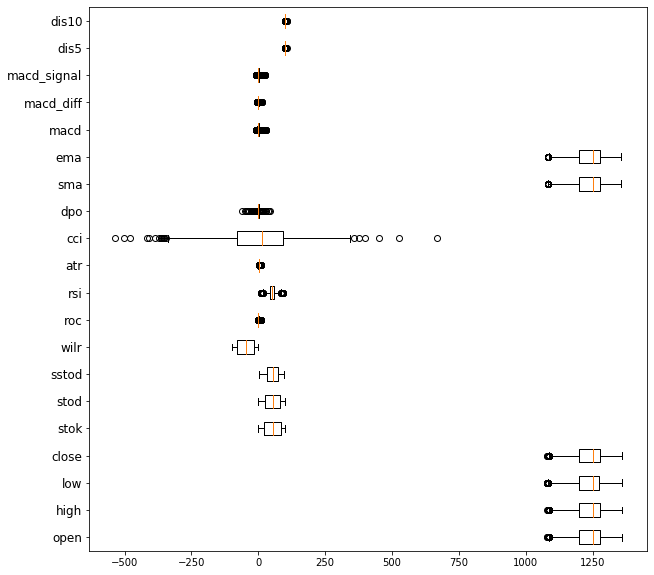

In [26]:
plt.figure(figsize=(10,10))
plt.boxplot(X.values,vert=False)
plt.yticks(np.arange(1,X.shape[1]+1),
           X.columns,fontsize=12)
plt.show()

## PreProcessed

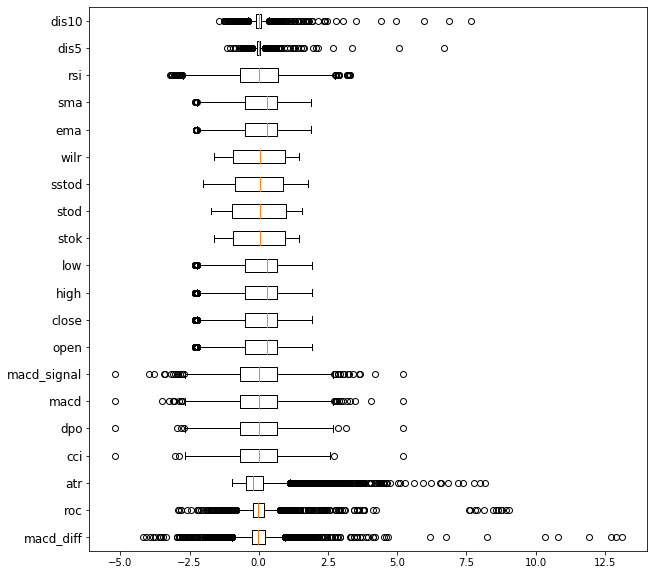

In [27]:
# tempX = tempX.drop(columns=['cci'])
plt.figure(figsize=(10,10))
plt.boxplot(preproX.values,vert=False)
plt.yticks(np.arange(1,preproX.shape[1]+1),
           preproX.columns,fontsize=12)
plt.show()

## Pre Processed 2.0

In [13]:
featurePreProcessing = {'open':'std',
                        'close':'std',
                        'high':'std',
                        'low':'std',
                        'stok':'std',
                        'stod':'std',
                        'sstod':'std',
                        'wilr':'std',
                        'ema':'std',
                        'sma':'std',
                        'dis5':'sub',
                        'dis10':'sub',
                        'macd_diff':'act',
                        'roc':'actde',
                        'atr':'actde',
                        'rsi':'std',
                        'cci':'quantgau',
                        'dpo':'quantgau',
                        'macd':'quantgau',
                        'macd_signal':'quantgau'}
ppX = pre_processing(X,featurePreProcessing,100).values

plt.figure(figsize=(10,10))
plt.boxplot(ppX.values,vert=False)
plt.yticks(np.arange(1,ppX.shape[1]+1),
           ppX.columns,fontsize=12)
plt.show()

TypeError: pre_processing() missing 1 required positional argument: 'subBy'

## Split data into train and test set

In [15]:
#X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = X_train.reset_index(drop=True) 
X_test = X_test.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((320, 20), (36, 20), (320,), (36,))

In [16]:
# featurePreProcessing = {'open':'std',
#                         'close':'std',
#                         'high':'std',
#                         'low':'std',
                        
#                         'stok':'std',
#                         'stod':'std',
#                         'sstod':'std',
#                         'wilr':'std',
#                         'ema':'std',
#                         'sma':'std',
#                         'dis5':'sub',
#                         'dis10':'sub',
#                         'macd_diff':'act',
#                         'roc':'actde',
#                         'atr':'actde',
#                         'rsi':'std',
#                         'cci':'quantgau',
#                         'dpo':'quantgau',
#                         'macd':'quantgau',
#                         'macd_signal':'quantgau'}
featurePreProcessing = {col:'quantgau' for col in X.columns}
ppX_train,ppX_test = pre_processing(X_train,
                                       X_test,
                                       featurePreProcessing,
                                       100)

In [17]:
ppX_train.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [18]:
ppX_test.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [19]:
corr = ppX_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,open,high,low,close,stok,stod,sstod,wilr,roc,rsi,atr,cci,dpo,sma,ema,macd,macd_diff,macd_signal,dis5,dis10
open,1.00,0.94,0.94,0.93,0.20,0.30,0.35,0.20,0.22,0.36,0.43,0.23,-0.10,0.90,0.93,0.43,0.10,0.41,0.04,0.13
high,0.94,1.00,0.95,0.96,0.25,0.33,0.36,0.25,0.31,0.44,0.46,0.29,-0.17,0.87,0.90,0.45,0.15,0.42,0.14,0.21
low,0.94,0.95,1.00,0.96,0.24,0.30,0.34,0.24,0.23,0.39,0.39,0.26,-0.11,0.89,0.92,0.40,0.10,0.38,0.14,0.19
close,0.93,0.96,0.96,1.00,0.29,0.33,0.33,0.29,0.28,0.44,0.43,0.29,-0.12,0.87,0.91,0.42,0.14,0.39,0.19,0.25
stok,0.20,0.25,0.24,0.29,1.00,0.78,0.32,1.00,0.67,0.74,0.25,0.76,-0.34,0.04,0.10,0.41,0.63,0.17,0.69,0.80
stod,0.30,0.33,0.30,0.33,0.78,1.00,0.53,0.78,0.76,0.79,0.31,0.80,-0.43,0.10,0.16,0.57,0.75,0.30,0.43,0.71
sstod,0.35,0.36,0.34,0.33,0.32,0.53,1.00,0.32,0.54,0.59,0.36,0.42,-0.15,0.31,0.32,0.80,0.33,0.75,-0.05,0.13
wilr,0.20,0.25,0.24,0.29,1.00,0.78,0.32,1.00,0.67,0.74,0.25,0.76,-0.34,0.04,0.10,0.41,0.63,0.17,0.69,0.80
roc,0.22,0.31,0.23,0.28,0.67,0.76,0.54,0.67,1.00,0.84,0.29,0.77,-0.63,0.02,0.08,0.69,0.83,0.37,0.43,0.69
rsi,0.36,0.44,0.39,0.44,0.74,0.79,0.59,0.74,0.84,1.00,0.45,0.83,-0.38,0.18,0.24,0.78,0.70,0.53,0.56,0.77


In [24]:
X_train[['open','high']].corr()

,open,high
open,1.000000,0.999868
high,0.999868,1.000000


## Feature Selection

In [20]:
start = time.time()

## Setting up the model and corresponding parameters

rf = ensemble.RandomForestClassifier()
param_grid = {'knn': {'n_neighbors': [1,3,5,7,9,11,13,15,17,19]},
                  'rf': {'n_estimators': [50,100,200], 'max_features': ['auto', None], 'min_samples_leaf': [1, 5, 10]}}

## Setting parameters for grid search
cv_folds = 5
n_jobs = 1

## Performing grid search
grid_search = GridSearchCV(rf, param_grid['rf'], cv = cv_folds, n_jobs = n_jobs)
grid_search.fit(ppX_train,y_train)

# store the best hyperparameters and initialize a separate random forest with those parameters
rf_params = grid_search.best_params_
rf = ensemble.RandomForestClassifier(**rf_params)

# refit the random forest using only the correctly accessible training data
# and return feature importances. This is not the perfect solution but it is 
# better than extracting feature importances from the grid search above which 
# is refit on all data (also test set) of the inner folds

rf.fit(ppX_train, y_train)
rf_features =  rf.feature_importances_




In [21]:
# compute mean of importances across folds and select those above the mean
# rf_features = np.mean(rf_features, axis=0)            
threshold_value = np.mean(rf_features) 
rf_features_w = np.where(rf_features > threshold_value)[0]

end = time.time()

if verbose:
    print("RF Feature selection final best features: " + str(rf_features_w))
    print('The model selection took %.3f seconds.' % (end-start))

RF Feature selection final best features: [ 6  8  9 10 11 12 16 17 18 19]
The model selection took 74.003 seconds.


In [22]:
rf_params

{'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 50}

In [24]:
# Feature Importances
rf_features

array([0.02783679, 0.01875575, 0.02559521, 0.02280285, 0.02808044,
       0.06878836, 0.06013534, 0.02819709, 0.05525495, 0.04809484,
       0.08395329, 0.04495875, 0.10806843, 0.0316934 , 0.02047484,
       0.04203374, 0.06953943, 0.0516097 , 0.09432058, 0.06980622])

In [25]:
rf.score(ppX_test,y_test)

0.3611111111111111

In [23]:
# reduce data sets using selected features X_train = X_train[:, rf_features]
msX_test,msX_train = ppX_test.iloc[:, rf_features_w],ppX_train.iloc[:, rf_features_w]

# Refitting

rf.fit(msX_train,y_train)

# Evaluating
rf.score(msX_test,y_test)

# store selected features
# total_features[counter, :] = str(rf_features)

0.3888888888888889

In [24]:
corr = msX_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,sstod,roc,rsi,atr,cci,dpo,macd_diff,macd_signal,dis5,dis10
sstod,1.00,0.54,0.59,0.36,0.42,-0.15,0.33,0.75,-0.05,0.13
roc,0.54,1.00,0.84,0.29,0.77,-0.63,0.83,0.37,0.43,0.69
rsi,0.59,0.84,1.00,0.45,0.83,-0.38,0.70,0.53,0.56,0.77
atr,0.36,0.29,0.45,1.00,0.32,-0.09,0.18,0.44,0.09,0.20
cci,0.42,0.77,0.83,0.32,1.00,-0.38,0.77,0.25,0.61,0.82
dpo,-0.15,-0.63,-0.38,-0.09,-0.38,1.00,-0.55,-0.08,-0.10,-0.31
macd_diff,0.33,0.83,0.70,0.18,0.77,-0.55,1.00,0.06,0.42,0.74
macd_signal,0.75,0.37,0.53,0.44,0.25,-0.08,0.06,1.00,-0.13,0.01
dis5,-0.05,0.43,0.56,0.09,0.61,-0.10,0.42,-0.13,1.00,0.83
dis10,0.13,0.69,0.77,0.20,0.82,-0.31,0.74,0.01,0.83,1.00


## Logistic Regression in Tensorflow

In [25]:
#### Building a Logistic Regression Model in Tensorflow
msX_train = ppX_train.copy(deep=True)
msX_test = ppX_test.copy(deep=True)
## Setting up data
NUMERIC_COLUMNS = msX_train.columns

feature_columns = []

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
    
## Arange data correctly
train_input_fn = make_input_fn(msX_train, y_train.astype(int))
eval_input_fn = make_input_fn(msX_test, y_test.astype(int), num_epochs=1, shuffle=False)

## Inspecting the data
ds = make_input_fn(msX_train, y_train.astype(int), batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['sstod'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())
    
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns,n_classes=3)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.4722222, 'average_loss': 1.0821623, 'loss': 1.0469733, 'global_step': 100}


In [26]:
pred_dicts = list(linear_est.predict(eval_input_fn))
print(len(pred_dicts))
pred_dicts[0]
# probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

# probs.plot(kind='hist', bins=20, title='predicted probabilities')

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\PC\AppData\Local\Temp\tmpyrbgw1ar\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
36


{'logits': array([-0.17374697,  0.4323543 , -0.18306282], dtype=float32),
 'probabilities': array([0.26150647, 0.47941193, 0.2590816 ], dtype=float32),
 'class_ids': array([1], dtype=int64),
 'classes': array([b'1'], dtype=object),
 'all_class_ids': array([0, 1, 2]),
 'all_classes': array([b'0', b'1', b'2'], dtype=object)}

In [28]:
pd.DataFrame([pred['probabilities'] for pred in pred_dicts]).shape # this shape depends on num_epocs

(36, 3)

In [43]:
scoreFunction(y_test,
              pred_dicts,
              'roc_auc_ovr',
              ['roc_auc_ovr',
              'roc_auc_ovo',
              'f1_score',
              'log_loss'])

roc_auc_ovr: 0.63076
roc_auc_ovo: 0.63063
f1_score: 0.45759
log_loss: 1.08216


0.63076

## Lets test some performance

### Lets test different preprocessing methods

In [81]:
for ppm in ['std','quantgau','quantuni','pow','minmax']:#'act','actde',
    print('The preprocessing method tested is: %s\n' % ppm)
    testDict = {col:ppm for col in X.columns}
    performanceTesting(X,y,5,2020,testDict,verbose=0)
    print('\n')

The preprocessing method tested is: std

Scores:  [0.3903186274509804, 0.3948497854077253, 0.3905579399141631, 0.39607602697731453, 0.38381361128142244]
Average Score: 0.391 (0.004)


The preprocessing method tested is: quantgau

Scores:  [0.3860294117647059, 0.4064990803188228, 0.39914163090128757, 0.38994481912936846, 0.37216431637032493]
Average Score: 0.391 (0.012)


The preprocessing method tested is: quantuni

Scores:  [0.39950980392156865, 0.39914163090128757, 0.3905579399141631, 0.39362354383813614, 0.3727774371551196]
Average Score: 0.391 (0.010)


The preprocessing method tested is: pow

Scores:  [0.39276960784313725, 0.39546290619251995, 0.3746167995095034, 0.3917841814837523, 0.38136112814224404]
Average Score: 0.387 (0.008)


The preprocessing method tested is: minmax

Scores:  [0.39644607843137253, 0.3825873697118332, 0.37155119558553035, 0.3911710606989577, 0.4009809932556714]
Average Score: 0.389 (0.010)




## Pre-Process features individually

In [19]:
featurePreProcessing = {'open':'std',
                        'close':'std',
                        'high':'std',
                        'low':'std',
                        'stok':'std',
                        'stod':'std',
                        'sstod':'std',
                        'wilr':'std',
                        'ema':'std',
                        'sma':'std',
                        'dis5':'sub',
                        'dis10':'sub',
                        'macd_diff':'act',
                        'roc':'actde',
                        'atr':'actde',
                        'rsi':'std',
                        'cci':'quantgau',
                        'dpo':'quantgau',
                        'macd':'quantgau',
                        'macd_signal':'quantgau'}
performanceTesting(X,y,5,2020,featurePreProcessing,verbose=0)

Scores:  [0.18309859154929578, 0.15714285714285714, 0.21428571428571427, 0.14285714285714285, 0.17142857142857143]
Average Score: 0.174 (0.024)


## Connect to SQL Database

In [26]:
server =  'fmnskln.database.windows.net' #'<server>.database.windows.net'
database = 'aggregateData'
username = 'fmnsklnucph'
password = pd.read_csv('../secrets/sql_pw.txt', header=None).values[0][0]
driver= '{ODBC Driver 17 for SQL Server}'
cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password,
                     autocommit=True)
cursor = cnxn.cursor()
#cursor.execute("SELECT TOP 20 pc.Name as CategoryName, p.name as ProductName FROM [SalesLT].[ProductCategory] pc JOIN [SalesLT].[Product] p ON pc.productcategoryid = p.productcategoryid")

In [14]:
cursor.execute("SELECT * FROM Agg_1m")

In [15]:
cursor.fetchall()

[('GOOG', datetime.date(2020, 4, 1), 0, Decimal('1122.26000'), Decimal('1127.22000'), Decimal('1119.51000'), Decimal('1126.12000'), None)]

In [26]:
# works
cursor.fast_executemany = False
result = [['GOOG', '20200401', 2, 1122.26, 1127.22, 1119.51, 1126.12]]
cursor.executemany('INSERT INTO [dbo].[Agg_1m] ([ticker], [time_date], [time_group], [open_price], [high_price], [low_price], [close_price]) VALUES (?, ?, ?, ?, ?, ?, ?)', result)


In [34]:
import datetime

In [38]:
datetime.datetime.strptime('20200401','%Y%m%d') #.strftime('%Y-%m-%d') #strptime(a, '%Y%m%d').strftime('%m/%d/%Y')

'2020-04-01'

In [70]:
cursor.fast_executemany = False  # new in pyodbc 4.0.19

sql = "INSERT INTO [dbo].[Agg_1m] ([ticker], [time_date], [time_group], [open_price], [high_price], [low_price], [close_price]) VALUES (?, ?, ?, ?, ?, ?, ?)"
params = tt.values.tolist() #[['GOOG', datetime.datetime.strptime('20200401','%Y%m%d'), 5, 1122.26, 1127.22, 1119.51, 1126.12]] #[(f'txt{i:06d}',) for i in range(1000)]
t0 = time.time()
cursor.executemany(sql, params)
print(f'{time.time() - t0:.1f} seconds')

471.0 seconds


In [71]:
# try optimizing
tt = candles_pd.copy()
tt.columns = candles_pd.columns.droplevel(0)
tt.reset_index(drop=False, inplace=True)
tt.insert(loc=0, column='ticker', value='GOOG')
tt['Date'] = pd.to_datetime(tt['Date'], format='%Y%m%d') #datetime.datetime.strptime(tt['Date'],'%Y%m%d')
tt.values

array([['GOOG', Timestamp('2020-04-01 00:00:00'), 0, ..., 1127.22,
        1119.51, 1126.12],
       ['GOOG', Timestamp('2020-04-01 00:00:00'), 1, ..., 1128.0, 1120.0,
        1126.92],
       ['GOOG', Timestamp('2020-04-01 00:00:00'), 2, ..., 1127.4,
        1124.02, 1125.44],
       ...,
       ['GOOG', Timestamp('2020-04-30 00:00:00'), 387, ..., 1348.99,
        1346.75, 1348.92],
       ['GOOG', Timestamp('2020-04-30 00:00:00'), 388, ..., 1350.0,
        1348.44, 1349.94],
       ['GOOG', Timestamp('2020-04-30 00:00:00'), 389, ..., 1352.85,
        1346.0, 1348.8]], dtype=object)

In [69]:
cursor.fast_executemany = True  # new in pyodbc 4.0.19

sql = "INSERT INTO [dbo].[Agg_1m] ([ticker], [time_date], [time_group], [open_price], [high_price], [low_price], [close_price]) VALUES (?, ?, ?, ?, ?, ?, ?)"
params = tt.values.tolist() #[['GOOG', datetime.datetime.strptime('20200401','%Y%m%d'), 5, 1122.26, 1127.22, 1119.51, 1126.12]] #[(f'txt{i:06d}',) for i in range(1000)]
t0 = time.time()
cursor.executemany(sql, params)
print(f'{time.time() - t0:.1f} seconds')

50.9 seconds
